<a href="https://colab.research.google.com/github/mohibwaqarr/DVLM_Assignment0/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers -q
!pip install matplotlib -q

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


Success: Macaw Image Loaded.
Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca


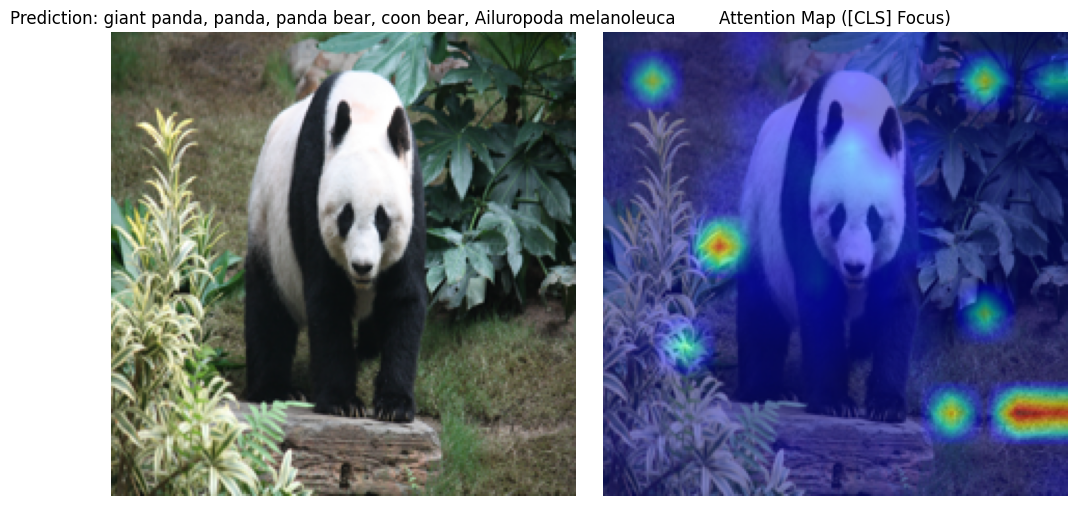

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import io
import requests
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True).to(device)

url = 'https://upload.wikimedia.org/wikipedia/commons/0/0f/Grosser_Panda.JPG'

headers = {'User-Agent': 'Mozilla/5.0'}
print(f"Downloading from: {url}")
response = requests.get(url, headers=headers, stream=True, timeout=10)
response.raise_for_status()
image = Image.open(io.BytesIO(response.content))
print("Success: Macaw Image Loaded.")

image = image.resize((224, 224))
if image.mode != "RGB":
    image = image.convert("RGB")

inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions
    logits = outputs.logits

predicted_label = model.config.id2label[logits.argmax(-1).item()]
print(f"Prediction: {predicted_label}")

last_layer_attn = attentions[-1]
attn_avg = torch.mean(last_layer_attn, dim=1)
cls_attn_map = attn_avg[0, 0, 1:]

grid_size = int(np.sqrt(cls_attn_map.shape[0]))
attn_heatmap = cls_attn_map.reshape(grid_size, grid_size).cpu().numpy()

attn_heatmap_resized = cv2.resize(attn_heatmap, (image.size[0], image.size[1]))
attn_heatmap_resized = (attn_heatmap_resized - attn_heatmap_resized.min()) / (attn_heatmap_resized.max() - attn_heatmap_resized.min())

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title(f"Prediction: {predicted_label}")
ax[0].axis('off')

ax[1].imshow(image)
ax[1].imshow(attn_heatmap_resized, cmap='jet', alpha=0.5)
ax[1].set_title("Attention Map ([CLS] Focus)")
ax[1].axis('off')

plt.tight_layout()
plt.savefig("vit_attention_map.png")
plt.show()

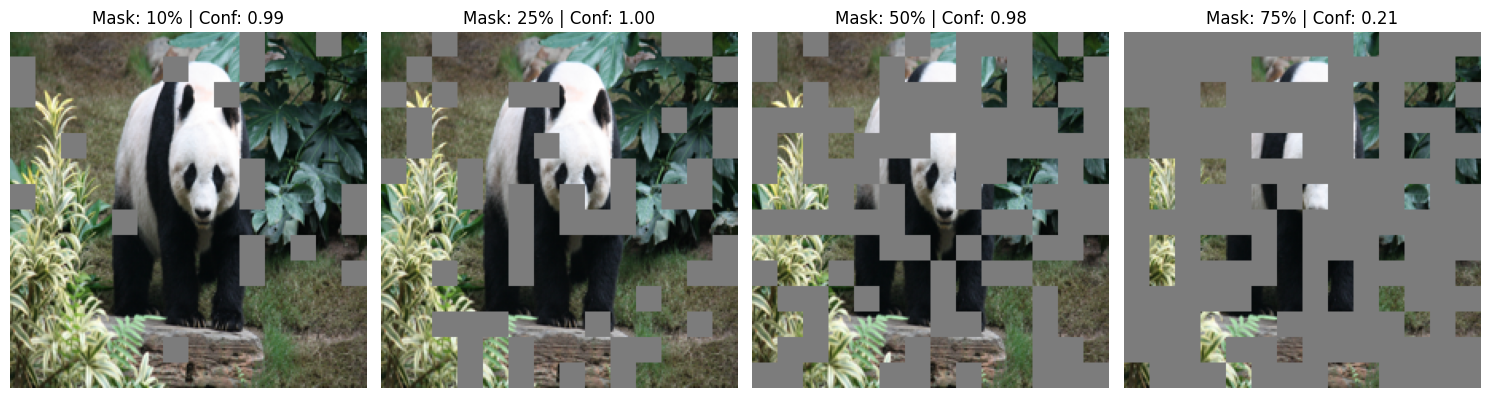

In [ ]:
def predict_masked(mask_ratio):
    pixel_values = inputs.pixel_values.clone()
    B, C, H, W = pixel_values.shape
    patch_size = 16
    total_patches = (H // patch_size) * (W // patch_size)

    num_masked = int(mask_ratio * total_patches)
    mask_indices = np.random.choice(total_patches, num_masked, replace=False)

    masked_pixels = pixel_values.clone()
    for idx in mask_indices:
        row = idx // (W // patch_size)
        col = idx % (W // patch_size)
        y1, y2 = row * patch_size, (row + 1) * patch_size
        x1, x2 = col * patch_size, (col + 1) * patch_size
        masked_pixels[:, :, y1:y2, x1:x2] = 0

    with torch.no_grad():
        outputs = model(pixel_values=masked_pixels)
        probs = outputs.logits.softmax(dim=-1)

    target_idx = logits.argmax(-1).item()
    return masked_pixels, probs[0, target_idx].item()

ratios = [0.10, 0.25, 0.50, 0.75]
plt.figure(figsize=(15, 5))

for i, r in enumerate(ratios):
    masked_img, conf = predict_masked(r)
    disp_img = masked_img[0].permute(1, 2, 0).cpu().numpy()
    disp_img = (disp_img - disp_img.min()) / (disp_img.max() - disp_img.min())

    plt.subplot(1, 4, i+1)
    plt.imshow(disp_img)
    plt.title(f"Mask: {int(r*100)}% | Conf: {conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("vit_masking_robustness.png")
plt.show()

In [ ]:
import torch
import gc
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import STL10
from tqdm.notebook import tqdm
from transformers import ViTImageProcessor, ViTForImageClassification

try:
    del inputs, outputs, attentions, logits, image
except:
    pass
gc.collect()
torch.cuda.empty_cache()
print("GPU Memory Cleared.")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name).to(device)
model.eval()

def custom_transform(image):
    return processor(images=image, return_tensors="pt")['pixel_values'][0]

print("Downloading/Loading STL-10...")
dataset = STL10(root="./data", split='test', download=True, transform=custom_transform)
subset_indices = list(range(1000))
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=8, shuffle=False)

def extract_features(pooling_type="cls"):
    features_list = []
    labels_list = []

    print(f"Extracting features ({pooling_type})...")

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            outputs = model(pixel_values=images, output_hidden_states=True)
            last_hidden_state = outputs.hidden_states[-1]

            if pooling_type == "cls":
                emb = last_hidden_state[:, 0, :]
            elif pooling_type == "mean":
                emb = last_hidden_state[:, 1:, :].mean(dim=1)

            features_list.append(emb.cpu())
            labels_list.append(labels)

    return torch.cat(features_list).numpy(), torch.cat(labels_list).numpy()

X_cls, y_cls = extract_features("cls")
torch.cuda.empty_cache()
X_mean, y_mean = extract_features("mean")
print("\nTraining Linear Probes...")
clf_cls = LogisticRegression(max_iter=2000, C=1.0)
clf_cls.fit(X_cls, y_cls)
acc_cls = clf_cls.score(X_cls, y_cls)

clf_mean = LogisticRegression(max_iter=2000, C=1.0)
clf_mean.fit(X_mean, y_mean)
acc_mean = clf_mean.score(X_mean, y_mean)

print("\n" + "="*40)
print(f"[CLS] Token Accuracy:  {acc_cls:.4f}")
print(f"Mean Pooling Accuracy: {acc_mean:.4f}")
print("="*40)

GPU Memory Cleared.
Downloading/Loading STL-10...
Extracting features (cls)...


  0%|          | 0/125 [00:00<?, ?it/s]

Extracting features (mean)...


  0%|          | 0/125 [00:00<?, ?it/s]


Training Linear Probes...

RESULTS FOR TASK 2.5
[CLS] Token Accuracy:  1.0000
Mean Pooling Accuracy: 1.0000
